# APS1070
#### Tutorial 2 - Anomaly Detection Algorithm using Gaussian Mixture Model 


##Tutorial

In this part of tutorial, we will implement an anomaly detection algorithm using the Gaussian model to detect anomalous behavior in a 2D dataset first and then a high-dimensional dataset.

Loading relevant libraries and the dataset

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


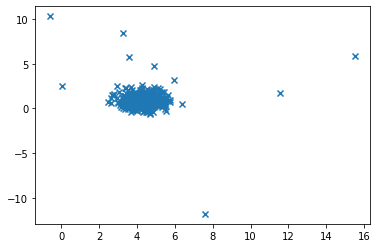

In [1]:
import numpy as np
import matplotlib.pyplot as plt


from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=1,
                       cluster_std=0.60, random_state=0)
X_append, y_true_append = make_blobs(n_samples=10,centers=1,
                                    cluster_std=5,random_state=0)
X = np.vstack([X,X_append])
y_true = np.hstack([y_true, [1 for _ in y_true_append]])
X = X[:, ::-1] # flip axes for better plotting
plt.scatter(X[:,0],X[:,1],marker="x");

Here we've manufactured a dataset where some points are visibly outliers from the main distribution.

We can see this from looking at the plot, but how do we robustly identify the outliers? 

That's where a Gaussian estimation comes in. For this dataset, we only need a single Gaussian, for which we are gonna calculate the mean and standard deviation. Then, we're able to find the points that don't seem likely to have originated from that distribution - these are our outliers!

First, we need to calculate the mean and variance for our data. Complete the function below to generate these values using these formulas:

$$\mu = \frac{1}{m} \sum_{i=1}^{m}X_i$$

$$\sigma^2 = \frac{1}{m} \sum_{i=1}^{m}(X_i-\mu)^2$$

In [2]:
def estimateGaussian(X):
    """
     This function estimates the parameters of a Gaussian distribution using the data in X
    """
    
    m = X.shape[0]
    
    #compute mean of X
    sum_ = np.sum(X,axis=0)
    mu = 1/m *sum_
    
    # compute variance of X
    var = 1/m * np.sum((X - mu)**2,axis=0)
    
    return mu,var
mu, sigma2 = estimateGaussian(X)

Now, we will calculate for each point in X, the probability of the distribution $N(\mu,\sigma^2)$ generating that point randomly. This has been completed for you, although it is important to understand how the calculation of the PDF works.

In [3]:
def multivariateGaussian(X, mu, sigma2):
    """
    Computes the probability density function of the multivariate gaussian distribution.
    """
    k = len(mu)
    
    sigma2=np.diag(sigma2)
    X = X - mu.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(sigma2)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma2) * X,axis=1))
    return p
p = multivariateGaussian(X, mu, sigma2)

Now that we have the probability of each point in the dataset, we can plot these on the original scatterplot:

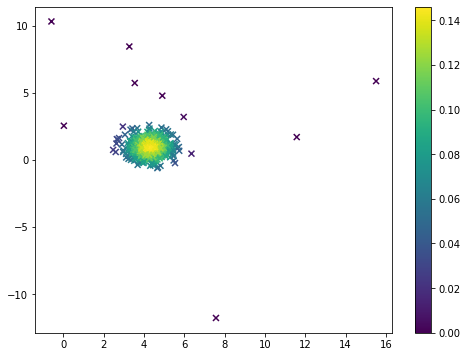

In [4]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='viridis');
plt.colorbar();

We're getting closer to the point where we can programmatically  identify our outliers for a single Gaussian distribution. The last step is to identify a value for $p$, below which we consider a point to be an outlier. We term this $\epsilon$.

In [5]:
#Choose a value for epsilon

epsilon = 0.02

Now we'll highlight on the scatter plot all points that are below $\epsilon$:

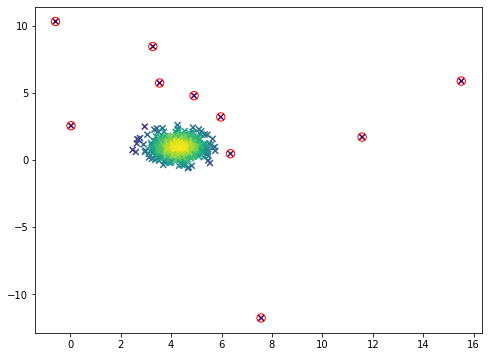

In [6]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='viridis');
# Circling of anomalies
outliers = np.nonzero(p<epsilon)[0]
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);

What value of epsilon did you choose? Why? ____ 

Play around with different values until you're happy with the plot above. 

We can additionally look at our model's classification performance another way. By sorting the points ascending by their probability, and classifying the first $k$ points as anomalous, we can determine the model's precision@k. Implement this in the cell below. 

* What is the highest value of K for which we get a precision of 1.0? ____
* What is the precision for K=4? ____

In [7]:
from sklearn.metrics import precision_score

for i in range(len(p)):
    mn = sorted(p)[i]
    sc = precision_score(
            y_true, p<=mn
        )
    if i == 4:
        print("Precision for k=4 is: ",sc)
    if sc < 1:
        print("highest value of K for which we get a precision of 1.0 : ",i)
        break


Precision for k=4 is:  1.0
highest value of K for which we get a precision of 1.0 :  10


You may have noticed that in this example, we are training and testing on the _entire_ dataset. This is absolutely not standard practice! You should _always_ split into a training and testing set. However, the reason that we can get away with this here is that we don't actually use labels at all during training - this is an _unsupervised_ machine learning task. Unsupervised learning methods are beneficial for anomaly detection because in the real world (i.e. testing!) we might come across types of outliers that we didn't see during training. We want to use a method that can handle this, and unsupervised methods are often better suited to this type of domain.

For the next section, we'll move to a Mixture of Gaussian models. Take a look at the following dataset:

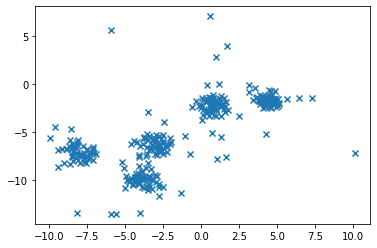

In [8]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
X, y_true = make_blobs(n_samples=400, centers=5,
                       cluster_std=0.60, random_state=1)
X_append, y_true_append = make_blobs(n_samples=50,centers=5,
                                    cluster_std=5,random_state=1)
X = np.vstack([X,X_append])
y_true = np.hstack([[0 for _ in y_true], [1 for _ in y_true_append]])
X = X[:, ::-1] # flip axes for better plotting

X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.33, random_state=1, shuffle=True)

plt.scatter(X_train[:,0],X_train[:,1],marker="x");

Okay, we have more than one cluster centre now. So what? Let's just ignore that and use the same model as before. 


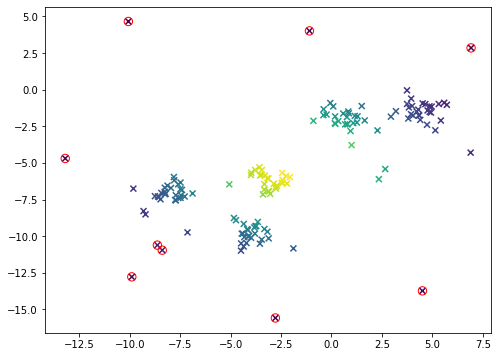

In [9]:
mu, sigma2 = estimateGaussian(X_train)
p = multivariateGaussian(X_test, mu, sigma2)
plt.figure(figsize=(8,6))
plt.scatter(X_test[:,0],X_test[:,1],marker="x",c=p,cmap='viridis');
outliers = np.nonzero(p<0.001)[0]
plt.scatter(X_test[outliers,0],X_test[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);


Uh oh. This model performs terribly. It's fit the mean to a section of space where we don't have _any_ points, and it has absolutely no idea which points are outliers! This was probably pretty obvious to you though. We need to move to a Mixture of Gaussians model - one in which we use multiple Gaussians to fit the data. We'll use `sklearn.mixture.GaussianMixture` to do this - or rather you will! Use the documentation, found [here](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) to initialise and fit a `GaussianMixture` object called `gm` in the cell below.

In [10]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components = 5,
                    covariance_type = 'full', random_state=0, )
gm.fit(X_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

Now we can use the method `gm.score_samples()` which gives a score based on how likely a point is to have been generated by any cluster:

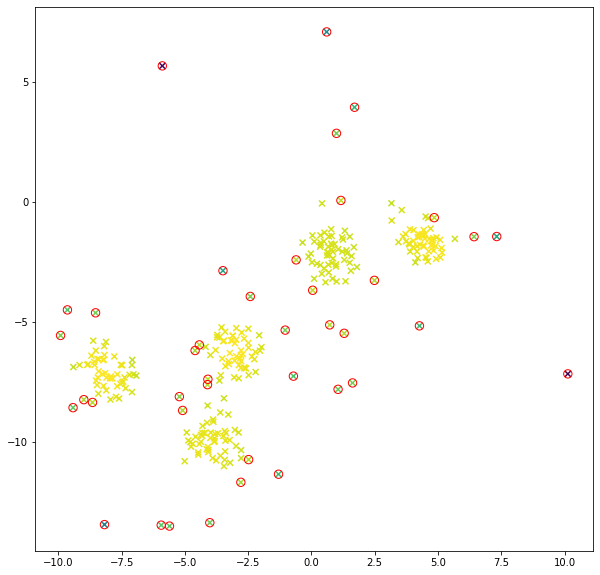

In [11]:
plt.figure(figsize=(10,10))
c = gm.score_samples(X_train)
plt.scatter(X_train[:,0],X_train[:,1],c=gm.score_samples(X_train),cmap='viridis',marker='x')

threshold= -4.8

outliers = np.nonzero(c<threshold)[0]
plt.scatter(X_train[outliers,0],X_train[outliers,1],marker="o",facecolor= "none",edgecolor="r",s=70)
plt.show()

What is the variable "`threshold`"? ______________ Why is it negative? __________________________
 
Now we can use the method `gm.predict_proba()` to spot the points in each of the clusters.

In [12]:
Non_Outliers=np.nonzero(c>=threshold)[0]
X_t=X_train[Non_Outliers]

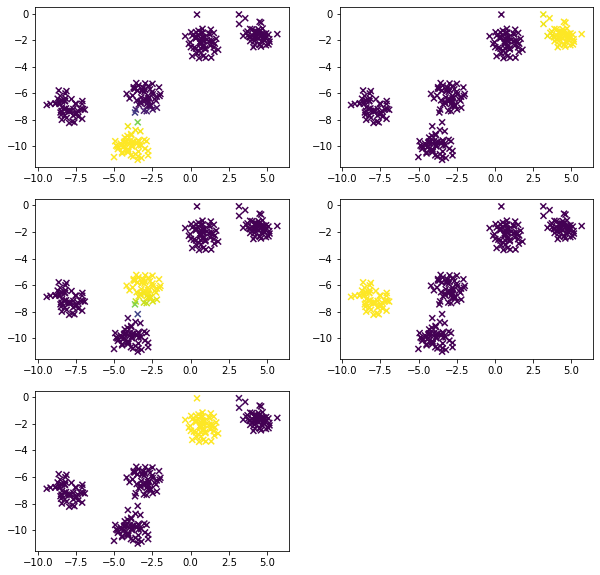

In [13]:
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(3,2,i+1)
    plt.scatter(X_t[:,0],X_t[:,1],c=gm.predict_proba(X_t)[:,i],cmap='viridis',marker='x')

1] What do functions `gm.score_samples()` and `gm.predict_proba()` return? ___________ 

2] Why it was important to run them in above sequence? ____________________

3] What is the difference between the two function?_______________________________


Our Mixture of Gaussians model is powerful! Not only is it unsupervised, it can both classify points into one of the K clusters we have, _and_ it can help us with our ultimate goal of identifying outlier points! We can do this by finding the points that no cluster wants to claim for itself.

In the cell below, complete the code and calculate these values and then compute precision@k for k=1, 10, and 100. The ROC curve code has been completed for you. 

* Is this model better or worse performing than the previous? ___
* Why might that be? ____

For a k of  1  the precision is  1.000  and the recall is  0.056
For a k of  10  the precision is  1.000  and the recall is  0.556
For a k of  100  the precision is  0.180  and the recall is  1.000


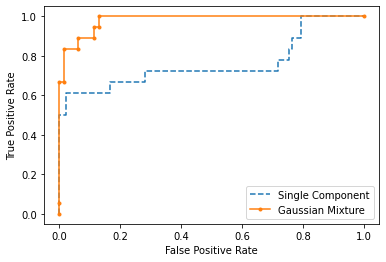

In [14]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#This part outputs the precision and recall on the test set

p_gm = gm.score_samples(X_test) #score_samples will compute the weighted log probabilities for each sample

for i in [1, 10, 100]: #Let's look at 3 different k values
   mn_gm = sorted(p_gm)[i] #We sort the points by probability, as before
   precision = precision_score(y_test, p_gm < mn_gm) #Here, we compare y_test labels to our picks using precision
   recall = recall_score(y_test, p_gm < mn_gm) #Here, we compare y_test labels to our picks using recall
   print('For a k of ',i,' the precision is ', '%.3f' % precision,' and the recall is ', '%.3f' % recall) #We print precision and recall three times

#This part computes the ROC curves for both models like we talked about in class

from sklearn.metrics import roc_curve
from matplotlib import pyplot
fpr_sc, tpr_sc, _ = roc_curve(y_test, 1-p)
fpr_gm, tpr_gm, _ = roc_curve(y_test, 1-p_gm)
pyplot.plot(fpr_sc, tpr_sc, linestyle = '--', label='Single Component')
pyplot.plot(fpr_gm, tpr_gm, marker='.', label='Gaussian Mixture')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

In [15]:
from sklearn.metrics import auc
print ("AUC of Single Component" , format( auc(fpr_sc, tpr_sc) , ".3f"))
print ("AUC of Gaussian Mixture" , format( auc(fpr_gm, tpr_gm) , ".3f"))

AUC of Single Component 0.760
AUC of Gaussian Mixture 0.980


In [16]:
from sklearn.metrics import roc_auc_score
print ("AUC of Single Component" , format(  roc_auc_score(y_test, 1-p)     , ".3f")  )
print ("AUC of Gaussian Mixture" , format(  roc_auc_score(y_test, 1-p_gm)  , ".3f")  )

AUC of Single Component 0.760
AUC of Gaussian Mixture 0.980


Let's look at a dataset that motivates using a Mixture of Gaussians model: Simpsons ratings.

Everyone knows that there's a certain point when The Simpsons "got bad", but can we use a Mixture of Gaussians to find out exactly when that was?

Load up the `simpsons.pickle` file using the cell below. It contains the IMDb rating for every simpsons episode.

In [17]:
!wget https://github.com/alexwolson/APS1070_data/raw/master/simpsons.pickle
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
with open('simpsons.pickle','rb') as f:
    simpsons = pickle.load(f)

--2020-09-30 01:34:20--  https://github.com/alexwolson/APS1070_data/raw/master/simpsons.pickle
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alexwolson/APS1070_data/master/simpsons.pickle [following]
--2020-09-30 01:34:20--  https://raw.githubusercontent.com/alexwolson/APS1070_data/master/simpsons.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26076 (25K) [application/octet-stream]
Saving to: ‘simpsons.pickle’

simpsons.pickle     100%[===================>]  25.46K  --.-KB/s    in 0.01s   

2020-09-30 01:34:21 (2.00 MB/s) - ‘simpsons.pickle’ saved [26076/26076]



Plot a histogram of the rating distribution for all Simpsons episodes. 


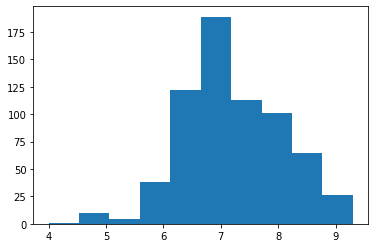

In [18]:
allratings = []
for v in simpsons.values():
    for v1 in v.values():
        allratings.append(v1)
plt.hist(allratings)
plt.show()

Next, use Gaussian Mixture to fit a Mixture of Gaussians to the Simpsons rating distribution. Since we are trying to distinguish between good and bad ratings, we only need 2 gaussians.

* What are the means for the two Gaussians fit by the model? __
* What about the standard deviations? __

In [19]:
gm = GaussianMixture(n_components=2)
gm.fit(np.array(allratings).reshape(-1,1))

print("Mean: ", gm.means_)
print(" \n \n StD: ", np.sqrt(gm.covariances_))


Mean:  [[6.7859272 ]
 [8.20449347]]
 
 
 StD:  [[[0.60218053]]

 [[0.45788767]]]


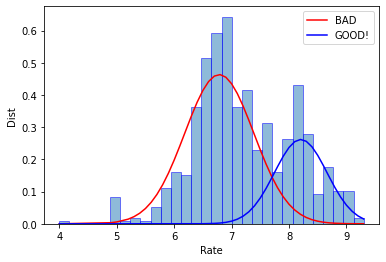

In [20]:
from matplotlib import rc
from sklearn import mixture
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import matplotlib.ticker as tkr
import scipy.stats as stats


x = np.array(allratings)

f = np.ravel(x).astype(np.float)
f=f.reshape(-1,1)

weights = gm.weights_
means = gm.means_
covars = gm.covariances_

plt.hist(f, bins=30, histtype='bar', density=True, ec='blue', alpha=0.5)

f_axis = f.copy().ravel()
f_axis.sort()
plt.plot(f_axis,weights[0]*stats.norm.pdf(f_axis,means[0],np.sqrt(covars[0])).ravel(), c='red', label = "BAD")
plt.plot(f_axis,weights[1]*stats.norm.pdf(f_axis,means[1],np.sqrt(covars[1])).ravel(), c='blue', label = "GOOD!")
plt.legend()
plt.xlabel("Rate")
plt.ylabel("Dist")
plt.show()

Finally, using the `GuassianMixture.predict()` method, we can use maximum likelihood to estimate which distribution, good or bad, each episode belongs to. In the cell below, we have provided code to count the number of episodes predicted to be in the "good" distribution per season, and plot for the same.
Understand the code and answer the question.

* Where is the notable drop-off point? __
* What is the first season with 0 good episodes? __


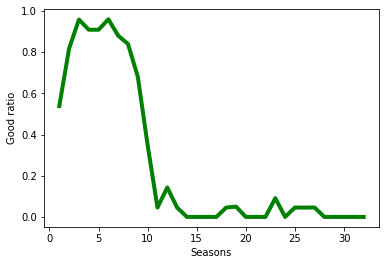

In [21]:
#Let's first associate each component with a good or bad season
if gm.means_[0,0] > gm.means_[1,0]: #True if first component is the good season (ie, higher mean)
     Good_season_index = 0
else:
     Good_season_index = 1

Xs = []
Ys = []
simpsons = dict(sorted(list(simpsons.items()), key=lambda x: x[0]))
for season, episodes in simpsons.items():
     bad = 0
     good = 0
     for episode in episodes.values():
          if gm.predict(np.array(episode).reshape(-1,1)) == Good_season_index:
               good += 1
          else:
               bad += 1
     Xs.append(season)
     Ys.append(good/(good+bad))
plt.plot(Xs, Ys, lw = 4, color = "green");
plt.xlabel("Seasons")
plt.ylabel("Good ratio")
plt.show()